## **FAIR VALUE PPP CALCULATOR (DRAFT)**
**Authors:** Debborah Lucas, Jorge J. Montesinos<br>
MIT Golub Center for Finance and Policy: http://gcfp.mit.edu/)<br>
<br>
**Objective:** Develop a fair value APV framework for assessing public infrastructure projects and the various claims associated with them. 

In [12]:
## Install packages
# install.packages("tidyverse")
# install.packages("optiRum")
# install.packages("FinCal")
library(tidyverse)
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)
library(optiRum)
library(FinCal)
library(purrr)

### Example: valuing a toll road
The hypothetical base case cash flows conform to the typical pattern of toll revenues net of capital expenditures, and operating and maintenance costs. 
Here the project is assumed to start in **2018**. <br>
Scale and some features are loosely based on projections that were made for part of the California Highway SR-91 Corridor improvement Project:
- 5 years construction, then 35 year concession to private partner (calibrated to 2018 market conditions)
- Projected net cash flows follow typical S-shaped pattern

In [13]:
# Load data (Hypothetical case):
df <- read_csv("C:/Users/Montesinos/BH my notebooks/BH r_model (MIT)/BH_p3_calculator/BH_data_hyp_case_v2.csv")

#### Net cash flows (net_cfs):
df <- df %>%
  mutate(net_cfs = revs - capital - o_m)
head(df)

Parsed with column specification:
cols(
  time = col_double(),
  revs = col_double(),
  capital = col_double(),
  o_m = col_double()
)


time,revs,capital,o_m,net_cfs
0,0,0.0e+00,0,0.0e+00
1,0,1.2e+08,0,-1.2e+08
2,0,1.2e+08,0,-1.2e+08
3,0,1.2e+08,0,-1.2e+08
4,0,1.2e+08,0,-1.2e+08
5,0,1.2e+08,0,-1.2e+08


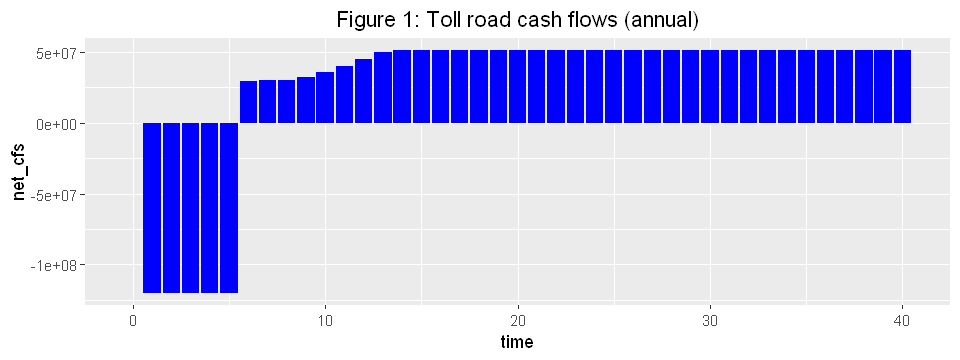

In [14]:
# Plot Net cash flows (annual)
ggplot(df, aes(x=time, y=net_cfs)) + 
    geom_col(fill ="blue") + 
    ggtitle("Figure 1: Toll road cash flows (annual)") +
    theme(plot.title = element_text(hjust="0.5"))

# Change plot size to 4 x 3
options(repr.plot.width=8, repr.plot.height=3)

### INPUTS 

**Volatility:** <br>
- Cash flow volatility based on DOT data from 1999-2016 on 15 toll projects https://www.fhwa.dot.gov/policyinformation/statistics.cfm <br>
- For nominal (real) toll revenues, the coefficient of variation averages .30 (.40), with a standard deviation of .14 (.13)
Volatility may be higher in early years when more demand and construction delay uncertainty

**Cost of capital for standalone project:** <br>
- Asset beta of 0.8, calculated as the average for “trucking” and “transportation” (*see Prof. Damadoran betas website at:* http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/Betas.html)
- CAPM inputs: risk-free rate of 2%, equity risk premium of 6%, inflation of 2% (see "Inputs" section above) 
- Nominal discount rate of .02 + .805(.06) = **6.8%**; real discount rate of **4.7%**.

In [15]:
## INPUTS 
# Project's generals:
n  <- 40            # total project duration (years)
n1 <- 5             # construction period (years)
n2 <- n-n1          # operation period (years)
rf <- 0.02          # risk-free rate (%)
inflation <- 0.021  # expected inflation
vol1 <- 0.30        # constant volatility
vol2 <- rep(c(0,0.5,0.4,0.3,0.2), c(6,2,2,2,29))   # varying volatility
vol3 <- tibble(vol1,vol2) # volatility dataframe

# Calculate cost of capital (ra):
Beta <- mean(c(0.80,0.81))             # asset beta: average btw transportation (.8) and trucking (.81)
premium <- 0.06                        # equity premium
ra <- rf + Beta*(premium) - inflation  # real fair value discount rate (%)
ra <- round(ra, digits = 3)

# Other inputs:
strike <- 15000000    # strike price (minimum guaranteed revenue)
durations <- c(5,10,20)


<br>

### BLACK'S MODEL CALCULATIONS:
**Minimum Revenue Guarantees:** <br>
Used to reduce risk for private partner. 
Technically this is a strip of put options that can be valued using **Black’s model** for commodity options, using the following equation:


$$p_{0,t} = e^{-ρ_t T} [XN(-d_2) - F_tN(-d1)]$$
where:

$$d_1 = \frac{ln(F_t/X) + σ_t^2\text{ }/\text{ } T}{σ_t\sqrt{T}} \text{   , and}\text{  } d_2 = d_1 - σ_t$$


- $T$ is the time to maturity of the option, i.e., the arrival time of the revenue flow; 
- $F_t$ is the forward price of the revenue flow at $T$;
- $X$ is the minimum guaranteed revenue, 
- $ρ_t$ is the risk-free rate on a continuous basis for maturity $T$; 
- $σ_t$ is the standard deviation of time $T$ revenues; 
- $N$ is the cumulative normal distribution; and $p_{0, t}$ is the value of the revenue guarantee for time $T$ as of time 0. <br>

[These calculations require an estimate of the volatility of future revenues, which we include in the Inputs section above.]

In [16]:
# Calculate Revenue Forward Prices (fw):
df <- df %>%
  mutate(fw = case_when(time < 13 ~ revs*exp(rf*time)/(1+ra)^time, 
                        time >= 13 ~ revs[13]*exp(rf*time)/(1+ra)^time)) %>%
  
  # Calculate Put value (put):
  # insert d1 and d2
  mutate(d1 = (log(fw/strike) + time*(vol1^2)/2) / (vol1*sqrt(time))) %>%
  mutate(d1 = replace(d1, d1 == -Inf, NA)) %>%
  mutate(d2 = d1-(vol1*sqrt(time))) %>%
  # insert N(-d1) and N(-d2)     
  mutate(N_d1 = pnorm(-d1), 
         N_d2 = pnorm(-d2)) %>%
  # insert put value (revenue guarantee) for each time t     
  mutate(put = exp(-rf*time)*(strike*N_d2 - fw*N_d1))
df
tail(df)

time,revs,capital,o_m,net_cfs,fw,d1,d2,N_d1,N_d2,put
0,0,0.0e+00,0,0,0,NA,NA,NA,NA,NA
1,0,1.2e+08,0,-120000000,0,NA,NA,NA,NA,NA
2,0,1.2e+08,0,-120000000,0,NA,NA,NA,NA,NA
3,0,1.2e+08,0,-120000000,0,NA,NA,NA,NA,NA
4,0,1.2e+08,0,-120000000,0,NA,NA,NA,NA,NA
5,0,1.2e+08,0,-120000000,0,NA,NA,NA,NA,NA
6,44689868,0.0e+00,15186757,29503111,38251134,1.641326,0.90647861,0.05036493,0.1823413,717167.1
7,45901851,0.0e+00,15950734,29951117,38282885,1.577312,0.78358677,0.05736186,0.2166413,915992.6
8,47044260,0.0e+00,16714711,30329549,38231409,1.526888,0.67835960,0.06339447,0.2487719,1114534.3
9,49329077,0.0e+00,17044000,32285077,39062125,1.513448,0.61344791,0.06508296,0.2697901,1256724.9


time,revs,capital,o_m,net_cfs,fw,d1,d2,N_d1,N_d2,put
35,73008389,0,21788000,51220389,26146670,1.200497,-0.5743265,0.1149731,0.7171266,3848901
36,73008389,0,21788000,51220389,25477428,1.194301,-0.6056985,0.1161800,0.7276425,3871953
37,73008389,0,21788000,51220389,24825317,1.188503,-0.6363261,0.1173177,0.7377181,3890063
38,73008389,0,21788000,51220389,24189896,1.183073,-0.6662516,0.1183902,0.7473748,3903507
39,73008389,0,21788000,51220389,23570740,1.177986,-0.6955135,0.1194011,0.7566332,3912553
40,73008389,0,21788000,51220389,22967431,1.173219,-0.7241474,0.1203540,0.7655124,3917459


In [17]:
# Value of Minimum Revenue Guarantees under different durations:
mrg_put   <- map_dbl(durations, ~sum(df$put[7:(6 +.x)]))
cat("The value of the minimum revenue guarantees for {5, 10, 20} years duration are: ","\n")
tibble(mrg_put)

The value of the minimum revenue guarantees for {5, 10, 20} years duration are:  


mrg_put
5298697
13157116
40530420


<br>

### TIFIA LOAN & MUNI BONDS:

We assume 70% debt funding, which is typical for highway projects. Total capital expenditures are $600 million, funded with *\\$420M of total debt*, and *\\$180M of equity* raised by the private partner. 
- **TIFIA guarantees** \\$120 million of the debt
- **Special activity muni bonds** fund \\$230 million
- The balance of \\$70 million is covered by unsubsidized private partner debt.

In [18]:
## TIFIA LOAN:
# Inputs:
princ_tf <- 120000000     # principal TIFIA ($)
rate_tf  <- 0.0225        # rate TIFIA (%)
rate_mkt <- rate_tf + rf  # market rate (%)
n_tf     <- 30            # maturity TIFIA (years)
start_tf <- 5             # start year TIFIA

# Calculations
pmt =(rate_tf*princ_tf)/(1-(1+rate_tf)^(-n_tf))  # payment (TIFIA)
pv_mkt = -PV(rate_mkt,n_tf,-pmt)                 # PV(debt payments) @market rate

# The present value of the credit subsidy would be the difference between:
#   1) PV(debt payments) discounted at subsidized borrowing rate (@2.25%) [i.e.: principal value of loan]
#   2) PV(debt payments) discounted at estimated market rate (@4.25)
pv_subsidy <- (princ_tf+pv_mkt)/(1+rate_mkt)^start_tf

# As percentage of TIFIA's principal (at year 5):
subsidy_perc <- (princ_tf+pv_mkt)/princ_tf

# Print results:
cat("pmt = ", pmt,"\n")
cat("pv_mkt = ", pv_mkt, "\n")
cat("The present value of TIFIA's credit subsidy is:", "\n")
cat("pv_subsidy = $", pv_subsidy, "\n")
cat("subsidy_perc = ", round(subsidy_perc*100, 2),"%","\n")

pmt =  5543921 
pv_mkt =  -93021547 
The present value of TIFIA's credit subsidy is: 
pv_subsidy = $ 21909715 
subsidy_perc =  22.48 % 


In [19]:
## MUNI:
# Inputs:
princ_muni <- 230000000     # principal MUNI ($)
rate_muni  <- 0.0475        # rate MUNI (%)
tax_muni   <- 0.2           # tax rate MUNI (%)
n_muni     <- 40            # maturity MUNI (years)

# Calculations
pv_muni = -PV(rate_muni,n_muni,-(tax_muni*rate_muni*princ_muni))                 # PV(debt payments) @market rate

# Print result:
cat("The present value of the MUNI subsidy is:", "\n")
cat("pv_muni = $", pv_muni)

The present value of the MUNI subsidy is: 
pv_muni = $ -38812190

<br>

### VALUE OF STANDALONE PROJECT

In [20]:
## NPV standalone project
# Generate fixed base CFs after t=12:
fixed_net_cfs <- df %>%
    transmute(revs, capital, o_m, fixed_net_cfs = case_when(time < 13 ~ revs - capital - o_m, 
                                                            time >= 13 ~ revs[13]- capital[13] - o_m[13])) %>%
    select(fixed_net_cfs)
# Calculate net present value (standalone project w/ fixed base CFs)
npv_project <- sum(fixed_net_cfs*(1 / (1 + ra))^(0:n))
irr_project <- irr(fixed_net_cfs[[1]])
irr_project2 <- irr(df$net_cfs)

# Print result:
cat("The present value of the standalone project is:", "\n")
cat("npv_project = $", npv_project,"\n")  
cat("irr_project = ", round(irr_project2*100, 2),"%","\n")
cat("irr_project_fixed = ", round(irr_project*100, 2),"%","\n")


The present value of the standalone project is: 
npv_project = $ 36722472 
irr_project =  5.7 % 
irr_project_fixed =  5.14 % 


<br>

**Sensitivity to discount rate**<br>
- If assume gov’t discount rate based on real Aa2 20-year muni rate of 1.72%, estimated value increases to **\\$451 million**
- If assume **real rate of 7%** (as per OMB guidance), estimated value falls to **-$117 million**
- IRR is 5.7%
- Extreme sensitivity because of long project horizon and low interest rate conditions
<br>


<br>

### Subsidies from TIFIA loan guarantees and muni bonds
Supporting assumptions and fair value calculation suggest magnitude of these subsidies:
- **TIFIA subsidy:** \\$22 million
- **Muni subsidy:** \\$39 million

These subsidies are a cost to the federal government. A state or local  government might add them to the APV of the project (see above **standalone project value = \\$37 million**). <br>
However, they are a transfer from federal to state and local taxpayers (and to the private partner if competition is limited). 